# Analysis & Run finetuning across all benchmarks and pretraining snapshots

* This notebook is used to analyze the output over all pretraining snapshots/checkpoints, and was used to generate the relevant figures in the ProteinBert paper (V1)


370 original dumps + 124 new dumps + 1 no dump = 495 initializations; x9 benchmakrs = 4455 total tasks.

> sbatch --array=0-4454 --output=/cs/phd/nadavb/logs/slurm_jobs/finetuning_from_different_pretraining_snapshots/job%j-%t.out --mem=50g -c1 --gres=gpu:1,vmem:8g --killable --requeue --time=1-0 /cs/phd/nadavb/proteinbert_project/bin/run_finetuning_from_different_pretraining_snapshots.sh


In [ ]:
import os
import re
from io import StringIO

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from IPython.display import display

In [1]:
LOG_DIRS = [
    # Final tweaking of the hyperparams
    '/cs/phd/nadavb/logs/slurm_jobs/finetuning_from_different_pretraining_snapshots/',
    # Everyting from scratch after fixing the final-epoch problem
#     '/cs/phd/nadavb/logs/slurm_jobs/finetuning_from_different_pretraining_snapshots_old_15/',
    # Everything from scratch (still with final epoch of 4096, which is too much)
#     '/cs/phd/nadavb/logs/slurm_jobs/finetuning_from_different_pretraining_snapshots_old_14/',
    # All 3,700 runs on the original dumps 
#     '/cs/phd/nadavb/logs/slurm_jobs/finetuning_from_different_pretraining_snapshots_old_9/',
    # Extra continued dumps + 10 runs with no pretraining
#     '/cs/phd/nadavb/logs/slurm_jobs/finetuning_from_different_pretraining_snapshots_old_13/',
]

tasks_info = []
task_id_to_results = {}
task_id = 0

for log_dir in LOG_DIRS:
    for log_file_name in os.listdir(log_dir):

        log_file_path = os.path.join(log_dir, log_file_name)
        
        with open(log_file_path, 'r') as f:
            log_content = f.read()

        try:
            original_task_id = int(re.search(r'task (\d+) of \d+', log_content).group(1))
        except:
            print('Failed parsing: %s' % log_file_name)
            continue

        dump_file_path, benchmark = re.search(r'Task dump file is (.*) and benchmark is (.+)\.', \
                log_content).groups()
        
        if dump_file_path == 'None':
            n_pretraining_epochs = None
        else:
            n_pretraining_epochs, = re.search(r'epoch_(\d+)_sample_\d+.pkl', dump_file_path).groups()
            n_pretraining_epochs = int(n_pretraining_epochs)
        
        is_done = ('Done.' in log_content)

        all_task_results = {}
        all_task_results['train_loss'] = np.array(list(map(float, re.findall(r'loss: ([\d\.]+)', log_content))))
        all_task_results['val_loss'] = np.array(list(map(float, re.findall(r'val_loss: ([\d\.]+)', log_content))))

        # Parsing the final results
        if is_done:
            for results_name in ['Training-set', 'Validation-set', 'Test-set']:

                relevant_log_section = log_content[log_content.index('*** %s performance: ***' % results_name):]
                raw_results = re.search(r'[ \t]+# records[^\[]*', relevant_log_section).group()
                results_chunk_dfs = []

                for raw_results_chunk in raw_results.split('\n\n'):
                    lines = raw_results_chunk.splitlines()
                    columns = re.split(r'\s{2,}', lines[0].replace('\\', '').strip())
                    raw_content = '\n'.join(lines[2:])
                    results_chunk_dfs.append(pd.read_csv(StringIO(raw_content), sep = '\s+', index_col = 0, names = columns))

                results = pd.concat(results_chunk_dfs, axis = 1)
                results.index.name = 'Model seq len'
                all_task_results[results_name] = results

        task_id_to_results[task_id] = all_task_results
        tasks_info.append((log_file_path, original_task_id, n_pretraining_epochs, benchmark, is_done))
        task_id += 1
    
tasks_info = pd.DataFrame(tasks_info, columns = ['log_file_path', 'original_task_id', 'n_pretraining_epochs', 'benchmark', 'is_done'])
tasks_info['benchmark'] = tasks_info['benchmark'].str.lower()
assert (tasks_info['n_pretraining_epochs'] != 0).all()
tasks_info['n_pretraining_epochs'] = tasks_info['n_pretraining_epochs'].fillna(0).astype(int)
display(tasks_info)

print('%d of %d tasks are done.' % (tasks_info['is_done'].sum(), len(tasks_info)))

Failed parsing: job4535979-0.out
Failed parsing: job4535978-0.out
Failed parsing: job4535977-0.out
Failed parsing: job4535976-0.out


,log_file_path,original_task_id,n_pretraining_epochs,benchmark,is_done
0,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,1169,61960,Phosphositeptm,True
1,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,564,116750,Disorder_secondary_structure,True
2,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,2455,115000,Profet_np_sp_cleaved,True
3,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,4028,52460,Secondary_structure,True
4,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,3948,74960,Disorder_secondary_structure,True
...,...,...,...,...,...
4450,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,3685,111500,Scop,True
4451,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,1950,14990,Disorder_secondary_structure,True
4452,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,1396,97950,Fluorescence,True
4453,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,1453,20240,Scop,True


4455 of 4455 tasks are done.


In [28]:
# New original dumps seem problematic after all
MAX_ORIGINAL_EPOCH = 92400

tasks_info = tasks_info[tasks_info['n_pretraining_epochs'] <= MAX_ORIGINAL_EPOCH]
display(tasks_info)

,log_file_path,original_task_id,n_pretraining_epochs,benchmark,is_done,metric,test_set_performance
0,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,1169,61960,Phosphositeptm,True,AUC,0.949855
3,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,4028,52460,Secondary_structure,True,Accuracy,0.737871
4,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,3948,74960,Disorder_secondary_structure,True,AUC,0.870335
9,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,4186,43710,Fluorescence,True,Spearman's rank correlation,0.662577
10,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,1607,21490,Secondary_structure,True,Accuracy,0.731690
...,...,...,...,...,...,...,...
4448,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,2857,52210,Scop,True,Accuracy,0.881153
4449,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,439,35460,Profet_np_sp_cleaved,True,AUC,0.980788
4451,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,1950,14990,Disorder_secondary_structure,True,AUC,0.883515
4453,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,1453,20240,Scop,True,Accuracy,0.852079


In [29]:
CHOSEN_METRICS = ['Spearman\'s rank correlation', 'AUC', 'Accuracy']

def select_metric(metric_columns):
    for metric in CHOSEN_METRICS:
        if metric in metric_columns:
            return metric

metrics = []
test_set_metric_values = []

for task_id in tasks_info.index:
    
    if not tasks_info.loc[task_id, 'is_done']:
        metrics.append(None)
        test_set_metric_values.append(np.nan)
        continue
    
    metric = select_metric(task_id_to_results[task_id]['Training-set'].columns)
    test_set_metric_value = task_id_to_results[task_id]['Test-set'].loc['All', metric]
    
    if pd.isnull(test_set_metric_value):
        assert metric == 'Spearman\'s rank correlation'
        test_set_metric_value = 0
    
    metrics.append(metric)
    test_set_metric_values.append(test_set_metric_value)

tasks_info['metric'] = metrics
tasks_info['test_set_performance'] = test_set_metric_values
display(tasks_info)

,log_file_path,original_task_id,n_pretraining_epochs,benchmark,is_done,metric,test_set_performance
0,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,1169,61960,Phosphositeptm,True,AUC,0.949855
3,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,4028,52460,Secondary_structure,True,Accuracy,0.737871
4,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,3948,74960,Disorder_secondary_structure,True,AUC,0.870335
9,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,4186,43710,Fluorescence,True,Spearman's rank correlation,0.662577
10,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,1607,21490,Secondary_structure,True,Accuracy,0.731690
...,...,...,...,...,...,...,...
4448,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,2857,52210,Scop,True,Accuracy,0.881153
4449,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,439,35460,Profet_np_sp_cleaved,True,AUC,0.980788
4451,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,1950,14990,Disorder_secondary_structure,True,AUC,0.883515
4453,/cs/phd/nadavb/logs/slurm_jobs/finetuning_from...,1453,20240,Scop,True,Accuracy,0.852079


In [30]:
done_tasks_info = tasks_info[tasks_info['is_done']]

benchmarks_and_metrics = done_tasks_info[['benchmark', 'metric']].drop_duplicates()
assert benchmarks_and_metrics['benchmark'].is_unique
benchmark_to_metric = benchmarks_and_metrics.set_index('benchmark')['metric'].to_dict()

test_set_performance = done_tasks_info.sort_values(['benchmark', 'n_pretraining_epochs']).set_index(['benchmark', 'n_pretraining_epochs'])\
        ['test_set_performance'].unstack().transpose().rename(columns = lambda benchmark: '%s (%s)' % (benchmark, \
        benchmark_to_metric[benchmark]))
display(test_set_performance)

benchmark,Disorder_secondary_structure (AUC),Fluorescence (Spearman's rank correlation),Phosphositeptm (AUC),Profet_np_sp_cleaved (AUC),Remote_homology (Accuracy),Scop (Accuracy),Secondary_structure (Accuracy),Signalp_binary (AUC),Stability (Spearman's rank correlation)
n_pretraining_epochs,,,,,,,,,
0,0.862067,0.647023,0.948348,0.940148,0.062674,0.593216,0.703780,0.990733,0.634429
240,0.855392,0.669464,0.950800,0.968186,0.068245,0.748279,0.703593,0.994358,0.682790
490,0.870944,0.674190,0.951032,0.977997,0.071031,0.754144,0.702797,0.995177,0.694324
740,0.868727,0.664505,0.951504,0.972332,0.084958,0.751084,0.710196,0.993358,0.708709
990,0.883810,0.670982,0.951733,0.974672,0.100279,0.750574,0.712556,0.988963,0.735085
...,...,...,...,...,...,...,...,...,...
91460,0.876319,0.665384,0.946563,0.981958,0.215877,0.882428,0.737590,0.994581,0.771075
91710,0.882414,0.636701,0.949718,0.983169,0.215877,0.887784,0.737319,0.996121,0.757080
91960,0.866868,0.668316,0.946989,0.979516,0.232591,0.894670,0.739061,0.995470,0.747935


In [31]:
test_set_performance.to_csv('/cs/phd/nadavb/proteinbert_project/data/test_set_performance.csv')

In [50]:
DISPLAY_BENCHMARK_NAMES = [
    # key, display_name
    ('secondary_structure', 'Secondary structure'),
    ('disorder_secondary_structure', 'Disorder'),
    ('remote_homology', 'Remote homology'),
    ('scop', 'Fold classes'),
    ('signalp_binary', 'Signal peptide'),
    ('phosphositeptm', 'Major PTMs'),
    ('profet_np_sp_cleaved', 'Neuropeptide cleavage'),
    ('fluorescence', 'Fluorescence'),
    ('stability', 'Stability'),
]

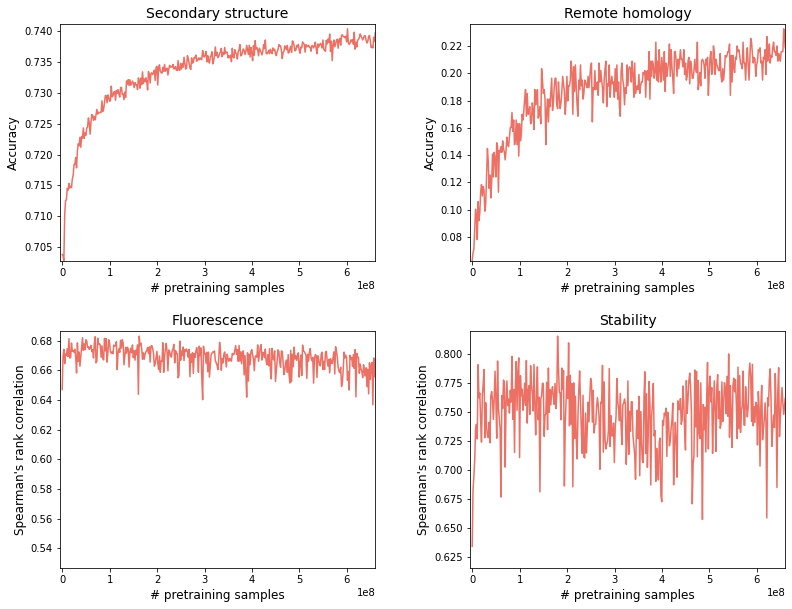

In [159]:
'''
Plot test-set results as a function of training epochs.
'''

N_SAMPLES_PER_EPOCH = 7139

# For the supplementary (all benchmarks)
# INCLUDED_BENCHMARKS = None
# fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (17, 15))

# For the paper itself (4 selected benchmarks)
INCLUDED_BENCHMARKS = {'remote_homology', 'secondary_structure', 'fluorescence', 'stability'}
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (13, 10))

fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

tasks_info_by_benchmark = tasks_info.groupby('benchmark')

if INCLUDED_BENCHMARKS is None:
    included_benchmarks = DISPLAY_BENCHMARK_NAMES
else:
    included_benchmarks = filter(lambda benchmark: benchmark[0] in INCLUDED_BENCHMARKS, DISPLAY_BENCHMARK_NAMES)

for (benchmark_key, benchmark_display), ax in zip(included_benchmarks, axes.flatten()):

    benchmark_tasks_info = tasks_info_by_benchmark.get_group(benchmark_key)
    ax.set_title(benchmark_display, fontsize = 14)
    
    if not benchmark_tasks_info['is_done'].any():
        continue
    
    benchmark_done_tasks_info = benchmark_tasks_info[benchmark_tasks_info['is_done']].sort_values('n_pretraining_epochs')
    metric, = benchmark_done_tasks_info['metric'].unique()
    x = N_SAMPLES_PER_EPOCH * benchmark_done_tasks_info['n_pretraining_epochs']
    y = benchmark_done_tasks_info['test_set_performance']
    
    ρ, _ = spearmanr(x, y)
    min_y_d = 0.2 * (1 - ρ**2)
        
    plot, = ax.plot(x, y, color = '#EC7063')
    
    ax.set_xlabel('# pretraining samples', fontsize = 12)
    ax.set_ylabel(metric, fontsize = 12)

    if len(benchmark_done_tasks_info) <= 10:
        ax.scatter(x, y)
        
    min_y = y.min()
    max_y = y.max()
    
    if max_y - min_y <= min_y_d:
        min_y = max_y - min_y_d
        
    max_y += 0.02 * (max_y - min_y)
        
    ax.set_ylim((min_y, max_y))
    ax.set_xlim((-5e06, x.max()))

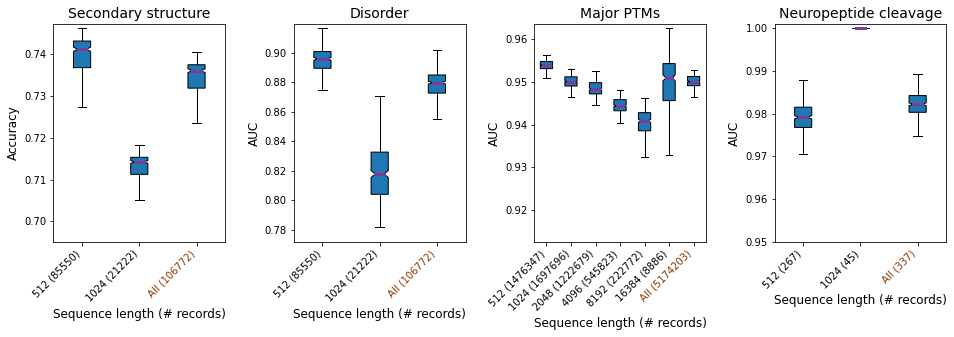

In [190]:
'''
Plot test-set results as a function of seq len.
'''

MIN_N_RECORDS = 25
MIN_Y_D = 0.05

INCLUDED_BENCHMARKS = {'secondary_structure', 'disorder_secondary_structure', 'phosphositeptm', 'profet_np_sp_cleaved'}
fig, axes = plt.subplots(ncols = 4, figsize = (16, 4))

fig.subplots_adjust(wspace = 0.4)

tasks_info_by_benchmark = tasks_info.groupby('benchmark')
included_benchmarks = filter(lambda benchmark: benchmark[0] in INCLUDED_BENCHMARKS, DISPLAY_BENCHMARK_NAMES)
# included_benchmarks = DISPLAY_BENCHMARK_NAMES # XXX

for (benchmark_key, benchmark_display), ax in zip(included_benchmarks, axes):

    benchmark_tasks_info = tasks_info_by_benchmark.get_group(benchmark_key)
    ax.set_title(benchmark_display, fontsize = 14)
    
    benchmark_done_tasks_info = benchmark_tasks_info[benchmark_tasks_info['is_done']].sort_values('n_pretraining_epochs')
    metric, = benchmark_done_tasks_info['metric'].unique()
    benchmark_test_set_results = [task_id_to_results[task_id]['Test-set'] for task_id in benchmark_tasks_info.index]
    
    n_records = benchmark_test_set_results[0]['# records']
    assert all((results['# records'] == n_records).all() for results in benchmark_test_set_results)
    
    benchmark_matrics = [results.drop(columns = ['# records']).squeeze() for results in benchmark_test_set_results]
    not_null_mask = benchmark_matrics[0].notnull()
    assert all((metrics.notnull() == not_null_mask).all() for metrics in benchmark_matrics)
    
    n_records_mask = (n_records >= MIN_N_RECORDS)
    n_records = n_records[not_null_mask & n_records_mask]
    benchmark_matrics = [metrics[not_null_mask & n_records_mask] for metrics in benchmark_matrics]
    benchmark_matrics = pd.concat(benchmark_matrics, axis = 1).transpose().reset_index(drop = True)
    
    boxplots = ax.boxplot(benchmark_matrics, showfliers = False, patch_artist = True, notch = True, \
            medianprops = dict(color = '#7D3C98', linewidth = 3))
    tick_labels = ax.set_xticklabels(['%s (%d)' % seq_len_and_n_records for seq_len_and_n_records in n_records.iteritems()], \
            rotation = 45, ha = 'right')
    tick_labels[-1].set_color('#873600')
    
    ax.set_xlabel('Sequence length (# records)', fontsize = 12)
    ax.set_ylabel(metric, fontsize = 12)
    
    whisker_values = np.concatenate([whisker.get_data()[-1] for whisker in boxplots['whiskers']])
    min_y = whisker_values.min() - 0.01
    max_y = whisker_values.max()
    
    if max_y - min_y <= MIN_Y_D:
        min_y = max_y - MIN_Y_D
        
    max_y += 0.02 * (max_y - min_y)
        
    ax.set_ylim((min_y, max_y))


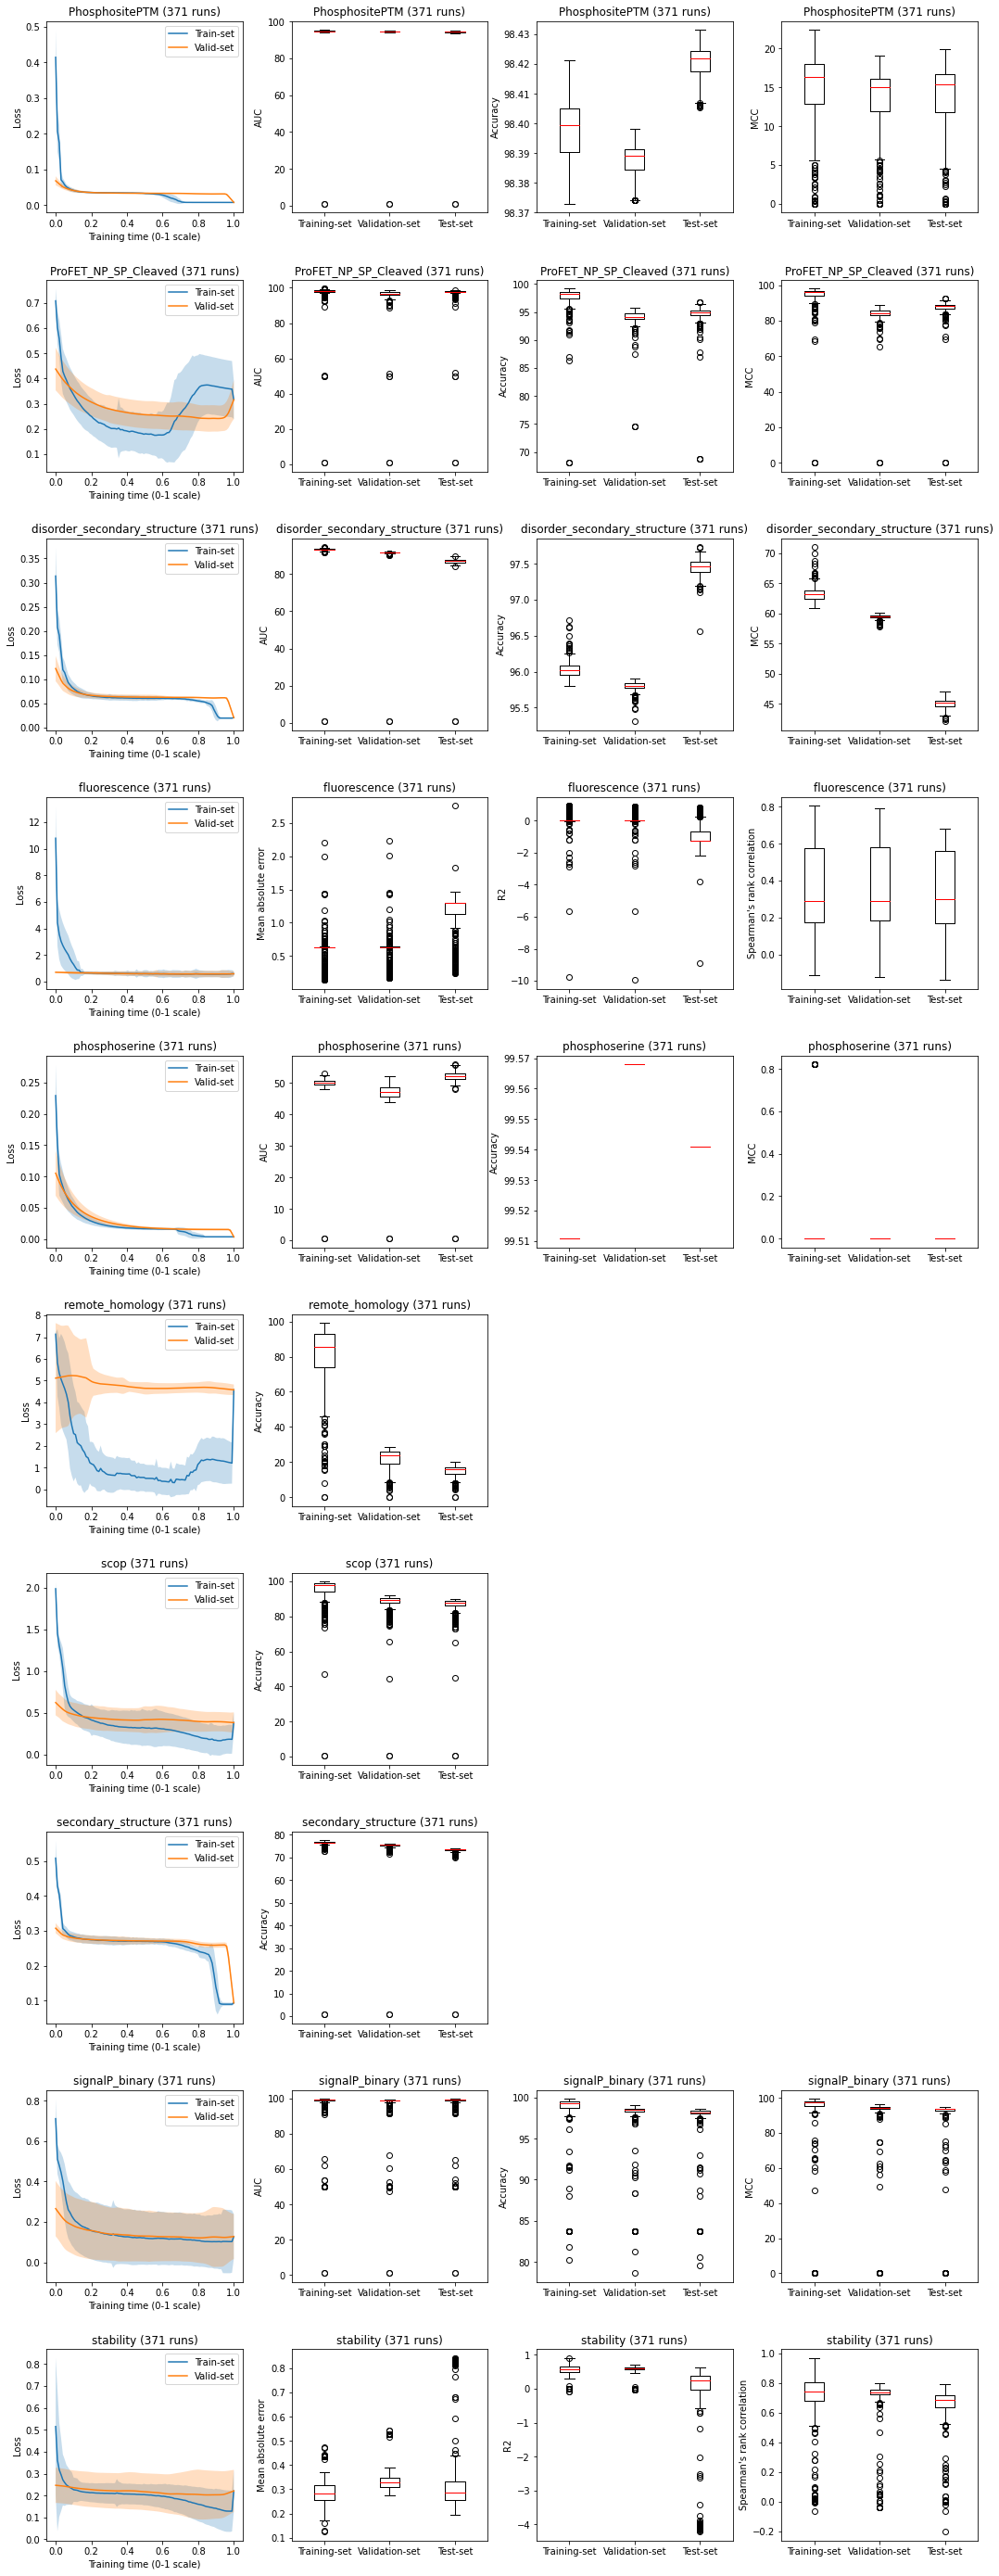

In [39]:
'''
Plot training dynamics and comparison between training-, validation- and test-set performances.
'''

COLS_TO_IGNORE = {'# records', 'Log loss'}

time_scale = np.linspace(0, 1, 100)

def interpolate_to_time_scale(values):
    global time_scale
    values_x = np.linspace(time_scale[0], time_scale[-1], len(values))
    return interp1d(values_x, values)(time_scale)

def get_loss_across_tasks(task_ids, loss_name):
    return np.concatenate([interpolate_to_time_scale(task_id_to_results[task_id][loss_name]).reshape(1, -1) for task_id in task_ids], axis = 0)

fig, axes = plt.subplots(figsize = (18, 50), nrows = 10, ncols = 4)
fig.subplots_adjust(hspace = 0.35, wspace = 0.25)

for (benchmark, benchmark_tasks_info), axes_row in zip(tasks_info.groupby('benchmark'), axes):

    benchmark_done_tasks_info = benchmark_tasks_info[benchmark_tasks_info['is_done']]
    title = '%s (%d runs)' % (benchmark, len(benchmark_tasks_info))
    
    ax = axes_row[0]
    ax.set_title(title)
    
    if not benchmark_tasks_info['is_done'].any():
        continue
    
    benchmark_train_losses = get_loss_across_tasks(benchmark_done_tasks_info['task_id'], 'train_loss')
    benchmark_valid_losses = get_loss_across_tasks(benchmark_done_tasks_info['task_id'], 'val_loss')
    benchmark_results = {results_name: benchmark_done_tasks_info['task_id'].apply(lambda task_id: \
            task_id_to_results[task_id][results_name].loc['All']) for results_name in ['Training-set', 'Validation-set', 'Test-set']}
    metrics = sorted(set.union(*(set(results.columns) for results in benchmark_results.values())) - COLS_TO_IGNORE)

    # Plotting training dynamics

    for loss_name, losses in [('Train-set', benchmark_train_losses), ('Valid-set', benchmark_valid_losses)]:
        loss_mean = losses.mean(axis = 0)
        loss_std = losses.std(axis = 0)
        ax.fill_between(time_scale, loss_mean - loss_std, loss_mean + loss_std, alpha = 0.25)
        ax.plot(time_scale, loss_mean, label = loss_name)

    ax.legend()
    ax.set_xlabel('Training time (0-1 scale)')
    ax.set_ylabel('Loss')

    # Plotting comparison between training-, validation- and test-set performances

    for i, ax in enumerate(axes_row[1:]):
        if i < len(metrics):
            metric = metrics[i]
            ax.boxplot([results[metric].dropna() for results in benchmark_results.values()], medianprops = dict(color = 'red'))
            ax.set_xticklabels(benchmark_results.keys())
            ax.set_ylabel(metric)
            ax.set_title(title)
        else:
            ax.set_visible(False)

# Get basic numbers of the pretraining dataset

In [36]:
import h5py

H5_DATASET_FILE_PATH = '/cs/phd/nadavb/proteinbert_project/data/original_dataset.h5'

with h5py.File(H5_DATASET_FILE_PATH, 'r') as h5f:
    
    print('%d samples' % len(h5f['seqs']))
    print('%d annotations' % len(h5f['included_annotations']))
    
    annotation_masks = h5f['annotation_masks']
    n_records_with_any_annotation = 0
    n_total_annotations = 0
    CHUNK_SIZE = 10000
    
    for i in range(0, len(annotation_masks), CHUNK_SIZE):
        print('%d/%d' % (i, len(annotation_masks)), end = '\r')
        chunk_annotation_masks = annotation_masks[i:(i + CHUNK_SIZE)]
        chunk_n_annotations_per_record = chunk_annotation_masks.sum(axis = 1)
        n_records_with_any_annotation += (chunk_n_annotations_per_record > 0).sum()
        n_total_annotations += chunk_n_annotations_per_record.sum()
        
    print('There are %d records with any annotation, and %d annotations in total.' % (n_records_with_any_annotation, n_total_annotations))

106206985 samples
8943 annotations
There are 46174654 records with any annotation, and 104455110 annotations in total.


# Calculating the number of processed samples per epoch

,epoch,sample
0,240,2500000
1,490,3900000
2,740,6000000
3,990,7700000
4,1240,9200000
...,...,...
376,94130,36200000
377,94380,38100000
378,94630,39900000
379,94880,41400000


Average # of samples per epoch: 7139


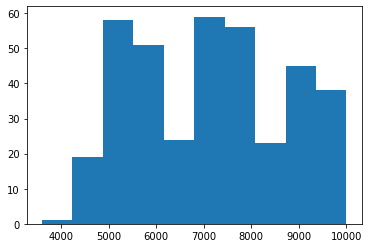

In [25]:
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

MODEL_DUMP_DIRS = ['/cs/labs/michall/nadavb/proteinbert_models/original_dumps', '/cs/labs/michall/nadavb/proteinbert_models/continue_original']

epoch_and_sample_pairs = []

for dump_dir in MODEL_DUMP_DIRS:
    for file_name in os.listdir(dump_dir):
        (epoch, sample), = re.findall(r'epoch_(\d+)_sample_(\d+)', file_name)
        epoch_and_sample_pairs.append((int(epoch), int(sample)))

epoch_and_sample_pairs = pd.DataFrame(epoch_and_sample_pairs, columns = ['epoch', 'sample']).sort_values('epoch').reset_index(drop = True)
display(epoch_and_sample_pairs)

epoch_and_sample_diffs = epoch_and_sample_pairs.diff().dropna()
epoch_and_sample_diffs = epoch_and_sample_diffs[epoch_and_sample_diffs['sample'] > 0]
samples_per_epochs = epoch_and_sample_diffs['sample'] / epoch_and_sample_diffs['epoch']

fig, ax = plt.subplots()
ax.hist(samples_per_epochs)

print('Average # of samples per epoch: %d' % samples_per_epochs.mean())

The types of episodes are:
* seq len = 128: batch size = 128 --> epoch = 12,800 samples
* seq len = 512: batch size = 64 --> epoch = 6,400 samples
* seq len = 1024: batch size = 32 --> epoch = 3,200 samples

Empircally, **the average is 7139 samples per epoch**, so it would be a reasonable mapping from #epochs to #samples.

# Pre-training performance along the snapshots

In [1]:
import sys

sys.path.append('/cs/phd/nadavb/github_projects/protein_bert')

In [2]:
import os
import random
import re

import numpy as np
import pandas as pd
import h5py
from IPython.display import display

import tensorflow as tf

from proteinbert import load_pretrained_model_from_dump
from proteinbert.conv_and_global_attention_model import create_model
from proteinbert.pretraining import DEFAULT_EPISODE_SETTINGS, EpochGenerator, DatasetHandler

MODEL_DUMP_DIRS = ['/cs/labs/michall/nadavb/proteinbert_models/original_dumps', '/cs/labs/michall/nadavb/proteinbert_models/continue_original']
H5_DATASET_FILE_PATH = '/cs/phd/nadavb/proteinbert_project/data/original_dataset.h5'

def create_epoch(seq_len, batch_size):
    
    np.random.seed(0)
    epoch_generator = EpochGenerator(episode_settings = [(seq_len, batch_size)])
    
    with h5py.File(H5_DATASET_FILE_PATH, 'r') as h5f:
        epoch_generator.setup(DatasetHandler(h5f))
        return epoch_generator.create_next_epoch()
    
assert len(tf.config.list_physical_devices('GPU')) > 0

dump_file_paths = sorted([os.path.join(dump_dir, file_name) for dump_dir in MODEL_DUMP_DIRS for file_name in os.listdir(dump_dir)])
random.seed(0)
random.shuffle(dump_file_paths)
    
seq_len_to_epoch = {seq_len: create_epoch(seq_len, batch_size) for seq_len, batch_size in DEFAULT_EPISODE_SETTINGS}
results = []

for dump_file_path in dump_file_paths:
    
    print('Dump file: %s' % dump_file_path)
    n_pretraining_epochs, = map(int, re.findall(r'epoch_(\d+)', dump_file_path))
    model_generator, _ = load_pretrained_model_from_dump(dump_file_path, create_model)
    
    for seq_len, batch_size in DEFAULT_EPISODE_SETTINGS:
        print('Seq len: %d' % seq_len)
        model = model_generator.create_model(seq_len)
        X, Y, sample_weights = seq_len_to_epoch[seq_len]
        seq_w, annots_w = sample_weights
        _, seq_loss, annots_loss = model.evaluate(X, Y, sample_weight = sample_weights, batch_size = batch_size)
        # It turns out that the losses calculated by keras (specifically crossentropy) are averaged across all positions, and not
        # just across positions that are relevant (according to our binary sample_weights), so we need to rescale the losses
        # by the percentage of relevant positions (which are wildly different between different max_seq_len options) to make
        # the results comparable.
        seq_loss /= seq_w.mean()
        annots_loss /= annots_w.mean()
        results.append([n_pretraining_epochs, seq_len, seq_loss, annots_loss])
        
del seq_len_to_epoch
results = pd.DataFrame(results, columns = ['n_pretraining_epochs', 'seq_len', 'seq_loss', 'annots_loss'])
display(results)

print('Done.')

[2021_04_09-11:01:25] Epoch sequence length distribution (for seq_len = 128): count: 12800.0, mean: 335.261796875, std: 329.2604105862499, min: 14.0, 25%: 150.75, 50%: 260.0, 75%: 416.0, max: 9350.0
[2021_04_09-11:01:37] Epoch sequence length distribution (for seq_len = 512): count: 6400.0, mean: 338.76890625, std: 341.7257836435594, min: 14.0, 25%: 152.0, 50%: 260.0, 75%: 416.25, max: 8378.0
[2021_04_09-11:01:49] Epoch sequence length distribution (for seq_len = 1024): count: 3200.0, mean: 340.560625, std: 359.5354154816217, min: 14.0, 25%: 153.0, 50%: 257.0, 75%: 416.0, max: 8378.0
Dump file: /cs/labs/michall/nadavb/proteinbert_models/original_dumps/epoch_36460_sample_49100000.pkl
Seq len: 128
100/100 [==============================] - 20s 37ms/step - loss: 0.2536 - output-seq_loss: 0.2532 - output-annotations_loss: 3.9198e-04
Seq len: 512
100/100 [==============================] - 9s 67ms/step - loss: 0.1452 - output-seq_loss: 0.1450 - output-annotations_loss: 1.5998e-04
Seq len: 10

,n_pretraining_epochs,seq_len,seq_loss,annots_loss
0,36460,128,0.269128,0.000904
1,36460,512,0.260811,0.000375
2,36460,1024,0.259626,0.000314
3,72710,128,0.266210,0.000840
4,72710,512,0.258031,0.000341
...,...,...,...,...
1138,56210,512,0.259999,0.000385
1139,56210,1024,0.260585,0.000504
1140,52210,128,0.264449,0.000594
1141,52210,512,0.260366,0.000380


Done.


In [3]:
results.to_csv('/cs/phd/nadavb/proteinbert_project/data/training_loss.csv', index = False)

In [37]:
results = pd.read_csv('/cs/phd/nadavb/proteinbert_project/data/training_loss.csv')

Max samples: 677848050


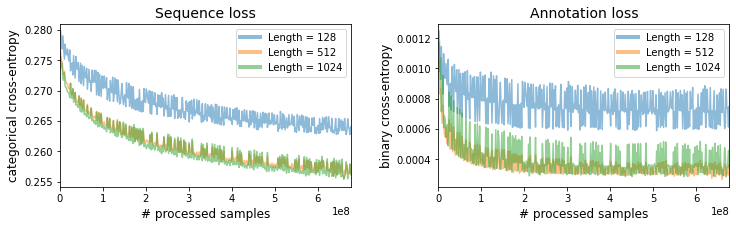

In [49]:
from matplotlib import pyplot as plt

N_SAMPLES_PER_EPOCH = 7139

LOSS_NAME_MAPPING = {
    # oroginal_name: (full_name, metric_name)
    'seq_loss': ('Sequence loss', 'categorical cross-entropy'),
    'annots_loss': ('Annotation loss', 'binary cross-entropy'),
}

max_samples = N_SAMPLES_PER_EPOCH * results['n_pretraining_epochs'].max()
print('Max samples: %d' % max_samples)

fig, axes = plt.subplots(ncols = 2, figsize = (12, 3))
fig.subplots_adjust(wspace = 0.3)

for i, (ax, loss) in enumerate(zip(axes, results.columns[-2:])):
    
    loss_full_name, loss_metric_name = LOSS_NAME_MAPPING[loss] 
    
    for seq_len, seq_len_results in results.groupby('seq_len'):
        seq_len_results = seq_len_results.sort_values('n_pretraining_epochs')
        ax.plot(N_SAMPLES_PER_EPOCH * seq_len_results['n_pretraining_epochs'], seq_len_results[loss], label = 'Length = %d' % seq_len, alpha = 0.5)
        
    legend = ax.legend()
    
    for line in legend.get_lines():
        line.set_linewidth(4.0)

    
    ax.set_title(loss_full_name, fontsize = 14)
    ax.set_xlim((0, max_samples))
    ax.set_xlabel('# processed samples', fontsize = 12)
    ax.set_ylabel(loss_metric_name, fontsize = 12)

# Estimate pre-training speed from logs

Average seconds per epoch: 25.5


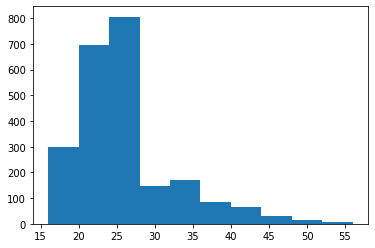

In [22]:
import re
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

LOG_FILE_PATH = '/cs/phd/nadavb/proteinbert_models/log_new_pretraining_continuing_original_1.txt'

# with open(LOG_FILE_PATH, 'r') as f:
#     results = re.findall('\[(.*)\] Epoch (\d+) \(current sample (\d+)\)\:', f.read())

# results = pd.DataFrame(results, columns = ['time', 'epoch', 'sample'])
# results['time'] = results['time'].apply(lambda raw_time: datetime.strptime(raw_time, '%Y_%m_%d-%H:%M:%S'))
# results['epoch'] = results['epoch'].astype(int)
# results['sample'] = results['sample'].astype(int)
# display(results)

diffs = results.diff().dropna()
assert (diffs['epoch'] == 1).all()
seconds_per_epoch = diffs['time'].apply(lambda delta: delta.total_seconds())

fig, ax = plt.subplots()
ax.hist(seconds_per_epoch)

print('Average seconds per epoch: %.1f' % seconds_per_epoch.mean())

On average, an epoch takes 25.5 seconds and includes 7139 samples (see above), i.e. **280 samples are processed per second**.

# Plot pre-training performance from logs 

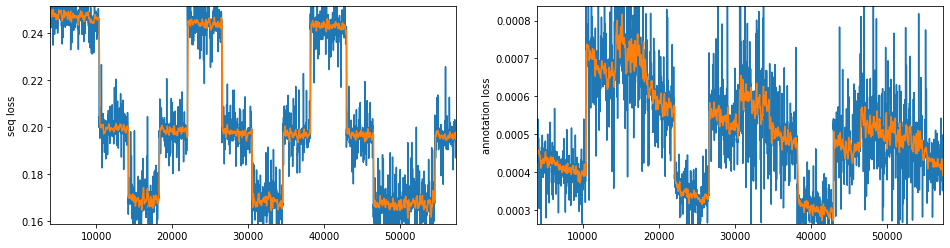

In [12]:
import re

import pandas as pd
import matplotlib.pyplot as plt

# LOG_FILE_PATH = '/cs/phd/nadavb/proteinbert_models/log_new_pretraining2.txt'
# LOG_FILE_PATH = '/cs/phd/nadavb/proteinbert_models/log_new_pretraining_on_original_dataset.txt'
# LOG_FILE_PATH = '/cs/phd/nadavb/proteinbert_models/log_new_pretraining_on_original_dataset_3.txt'
LOG_FILE_PATH = '/cs/phd/nadavb/proteinbert_models/log_new_pretraining_from_scratch_on_new_dataset.txt'

with open(LOG_FILE_PATH, 'r') as f:
    losses = re.findall(r'loss: ([\d\.e\+\-]*) - output-seq_loss: ([\d\.e\+\-]*) - output-annotations_loss: ([\d\.e\+\-]*)', f.read())
    
losses = pd.DataFrame(losses, columns = ['total', 'seq', 'annots']).applymap(float)
relevant_losses = losses

S = 4000
R = 100
R_LIM = 50

fig, axes = plt.subplots(ncols = 2, figsize = (16, 4))
axes[0].plot(relevant_losses.index, relevant_losses['seq'])
axes[0].plot(relevant_losses.index, relevant_losses['seq'].rolling(R).mean())
axes[0].set_ylabel('seq loss')
axes[1].plot(relevant_losses.index, relevant_losses['annots'])
axes[1].plot(relevant_losses.index, relevant_losses['annots'].rolling(R).mean())
axes[1].set_ylabel('annotation loss')

for ax, col in zip(axes, ['seq', 'annots']):
    ax.set_xlim((S, len(relevant_losses)))
    values = relevant_losses[col].rolling(R_LIM).mean().iloc[S:]
    ax.set_ylim((values.min(), values.max()))

# XXX Checking examples as a language model

In [2]:
import sys

sys.path.append('/cs/phd/nadavb/github_projects/protein_bert')

In [4]:
import numpy as np
import pandas as pd
import h5py
from IPython.display import display

import tensorflow as tf

from proteinbert.tokenization import index_to_token, n_tokens, token_to_index, ADDITIONAL_TOKENS
from proteinbert.model_generation import load_pretrained_model_from_dump
from proteinbert.pretraining import EpochGenerator, EpisodeDataManager, DatasetHandler
from proteinbert.conv_and_global_attention_model import create_model

MODEL_WEIGHTS_FILE_PATH = '/cs/phd/nadavb/proteinbert_models/new_original_2/epoch_590_sample_3800000.pkl'
H5_DATASET_FILE_PATH = '/cs/phd/nadavb/proteinbert_project/data/original_dataset.h5'

N = 3

def one_hot_vector(n, i):
    v = np.zeros(n)
    v[i] = 1
    return v

def baseline_pred(X_seqs, Y_true_seqs, p_seq_noise = 0.05):
    
    SPECIAL_TOKENS = {token_to_index[token_str] for token_str in ADDITIONAL_TOKENS}
    
    input_tokens = pd.Series(X_seqs)
    true_tokens = pd.Series(Y_true_seqs)
    token_counts = true_tokens[~true_tokens.isin(SPECIAL_TOKENS)].value_counts().to_dict()
    
    for token in range(n_tokens):
        if token in SPECIAL_TOKENS:
            token_counts[token] = 0
        elif token not in token_counts:
            token_counts[token] = 0
    
    token_counts = pd.Series(token_counts)
    token_freqs = token_counts / token_counts.sum()
    token_freqs = np.array([token_freqs.loc[token] for token in range(n_tokens)])
    
    baseline_Y_pred_seqs = []
    
    for input_token, true_token in zip(X_seqs, Y_true_seqs):
        if true_token in SPECIAL_TOKENS:
            baseline_Y_pred_seqs.append(one_hot_vector(n_tokens, true_token))
        elif input_token in SPECIAL_TOKENS or token_freqs[input_token] == 0:
            baseline_Y_pred_seqs.append(token_freqs) 
        else:
            baseline_Y_pred_seqs.append(p_seq_noise * token_freqs + (1 - p_seq_noise) * one_hot_vector(n_tokens, input_token))
            
    return np.array(baseline_Y_pred_seqs, dtype = float)

with h5py.File(H5_DATASET_FILE_PATH, 'r') as h5f:
#     test_set_indices, = np.where(h5f['test_set_mask'][:])
#     chosen_sample_indices = list(sorted(np.random.choice(test_set_indices, N)))
#     del test_set_indices
    chosen_sample_indices = list(sorted(np.random.randint(0, len(h5f['seqs']), N)))
    chosen_samples = DatasetHandler(h5f)[chosen_sample_indices]
    chosen_uniprot_ids = [uniprot_id.decode('utf8') for uniprot_id in h5f['uniprot_ids'][chosen_sample_indices]]
    
# So that true annotations won't be masked away here.
chosen_samples.test_set_flags = [False for _ in range(N)]
    
seq_lens = np.array(list(map(len, chosen_samples.seqs)))
max_seq_len = seq_lens.max()
model_seq_len = min(max_seq_len, 4096)
model_seq_len = 512 # We end up just forcing 512.
print('max_seq_len = %d, model_seq_len = %d' % (max_seq_len, model_seq_len))

episode = EpisodeDataManager(model_seq_len, batch_size = 1, n_batches_per_epoch = 1)
episode.sample_cache = chosen_samples

epoch_generator = EpochGenerator()
epoch_generator._current_episode = episode

model_generator, input_encoder = load_pretrained_model_from_dump(MODEL_WEIGHTS_FILE_PATH, create_model)
model = model_generator.create_model(model_seq_len)
    
for uniprot_id in chosen_uniprot_ids:
    
    print('UniProt ID: %s (https://www.uniprot.org/uniprot/%s)' % (uniprot_id, uniprot_id))

    X, Y_true, _ = epoch_generator._encode_epoch(*episode.encode_next_epoch())
    Y_pred = model.predict(X)
    
    X_seqs, X_annots = X
    Y_true_seqs, Y_true_annots = Y_true
    Y_pred_seqs, Y_pred_annots = Y_pred
    
    X_seqs = X_seqs.flatten()
    X_annots = X_annots.flatten()
    Y_true_seqs = Y_true_seqs.flatten()
    Y_true_annots = Y_true_annots.flatten()
    Y_pred_seqs = Y_pred_seqs[0, :, :]
    Y_pred_annots = Y_pred_annots.flatten()
    
    no_pad_mask = (Y_true_seqs != token_to_index['<PAD>'])
    effective_seq_len = int(no_pad_mask.sum())
    X_seqs = X_seqs[no_pad_mask]
    Y_true_seqs = Y_true_seqs[no_pad_mask]
    Y_pred_seqs = Y_pred_seqs[no_pad_mask]
    
    Y_pred_seqs_max = Y_pred_seqs.argmax(axis = -1)
    
    seq_loss = tf.keras.backend.eval(tf.keras.losses.sparse_categorical_crossentropy(tf.Variable(Y_true_seqs), \
            tf.Variable(Y_pred_seqs))).mean()
    baseline_Y_pred_seqs = baseline_pred(X_seqs, Y_true_seqs)
    baseline_seq_loss = tf.keras.backend.eval(tf.keras.losses.sparse_categorical_crossentropy(tf.Variable(Y_true_seqs), \
            tf.Variable(baseline_Y_pred_seqs))).mean()
    print('Seq loss: %.3g (baseline: %.3g)' % (seq_loss, baseline_seq_loss))

    seq_result = pd.DataFrame()
    seq_result['input'] = list(map(index_to_token.get, X_seqs))
    seq_result['pred'] = list(map(index_to_token.get, Y_pred_seqs_max))
    seq_result['true'] = list(map(index_to_token.get, Y_true_seqs))
    seq_result['p_input'] = Y_pred_seqs[np.arange(effective_seq_len), X_seqs]
    seq_result['p_pred'] = Y_pred_seqs[np.arange(effective_seq_len), Y_pred_seqs_max]
    seq_result['p_true'] = Y_pred_seqs[np.arange(effective_seq_len), Y_true_seqs]
    seq_result['p_true_factor'] = Y_pred_seqs[np.arange(effective_seq_len), Y_true_seqs] / baseline_Y_pred_seqs[np.arange(effective_seq_len), \
            Y_true_seqs]

    print('Sequence results:')

    with pd.option_context('display.max_columns', effective_seq_len):
        display(seq_result.transpose())
#         display(seq_result[(seq_result['true'] != seq_result['input']) | (seq_result['p_true'] < 0.9)].transpose())

    true_annots, = np.where(Y_true_annots)
    input_annots, = np.where(X_annots)
    relevant_annots = sorted(set(true_annots) | set(input_annots) | set(np.where(Y_pred_annots >= 0.05)[0]))

    print('Annotation results:')
    print('True annotations: %s' % true_annots)
    print('Input annotations: %s' % input_annots)
    print('Predicted annotations: %s' % ', '.join('%d (%.2g)' % (annot, Y_pred_annots[annot]) for annot in relevant_annots))
    print('*' * 100)

max_seq_len = 318, model_seq_len = 512
UniProt ID: A0A4R3L183_9BACL (https://www.uniprot.org/uniprot/A0A4R3L183_9BACL)
[2021_04_08-16:22:20] Epoch sequence length distribution (for seq_len = 512): count: 1.0, mean: 316.0, std: nan, min: 316.0, 25%: 316.0, 50%: 316.0, 75%: 316.0, max: 316.0
Seq loss: 12.2 (baseline: 0.286)
Sequence results:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315
input,<START>,M,S,K,L,A,G,I,F,P,G,Q,<PAD>,S,Q,Q,V,G,M,G,N,E,I,A,S,V,Y,D,Q,A,K,Q,I,F,L,E,A,D,E,V,L,G,D,S,L,S,T,L,C,F,E,G,P,E,E,V,L,R,L,T,A,N,T,V,P,A,I,L,T,T,S,V,A,C,Y,C,V,F,A,Q,T,G,V,T,P,D,F,V,A,G,H,S,L,G,E,Y,S,A,L,V,A,A,G,S,L,S,F,A,D,A,V,K,T,V,R,Q,R,G,K,<PAD>,M,E,D,A,P,P,A,G,V,G,A,M,S,A,V,L,N,E,D,R,E,R,L,D,E,V,C,V,T,V,S,K,E,G,F,V,V,E,P,A,N,Y,N,C,P,G,Q,I,A,I,S,G,H,K,E,A,W,E,E,A,G,K,K,A,L,E,A,G,A,R,R,V,I,P,L,S,V,S,G,P,F,H,S,S,L,Q,K,P,A,A,N,R,L,N,E,T,L,S,Q,V,T,I,H,D,A,K,I,P,V,L,A,N,V,T,A,Q,P,V,T,A,S,I,E,I,H,R,L,L,U,E,Q,V,A,S,P,V,K,W,E,D,S,V,R,D,M,I,E,Q,G,V,T,T,F,P,E,F,G,S,G,T,V,L,S,G,L,<OTHER>,K,K,V,D,R,K,V,T,T,Y,A,V,Q,D,S,K,S,<PAD>,E,N,V,L,N,Q,L,N,L,N,L,<END>
pred,<START>,<OTHER>,<END>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<END>,D,<START>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<END>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<END>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<END>,<END>,<END>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<END>,<OTHER>,<OTHER>,<END>,<END>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<END>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<END>,<END>,<START>,<OTHER>,<OTHER>,<END>,<END>,<OTHER>,<OTHER>,W,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<END>,<OTHER>,<END>,<OTHER>,D,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<END>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<END>,<END>,<OTHER>,<END>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<END>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTH

Annotation results:
True annotations: [840]
Input annotations: [ 840 7057]
Predicted annotations: 552 (0.15), 840 (0.74), 3633 (0.2), 7057 (0.00023)
****************************************************************************************************
UniProt ID: B1BBG9_CLOBO (https://www.uniprot.org/uniprot/B1BBG9_CLOBO)
[2021_04_08-16:22:22] Epoch sequence length distribution (for seq_len = 512): count: 1.0, mean: 320.0, std: nan, min: 320.0, 25%: 320.0, 50%: 320.0, 75%: 320.0, max: 320.0
Seq loss: 16 (baseline: 0.273)
Sequence results:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319
input,<START>,M,I,T,H,G,K,S,I,K,I,F,T,G,N,A,H,P,E,L,A,K,D,I,A,S,A,L,G,V,T,V,V,D,S,N,V,G,K,F,S,D,G,E,I,S,U,N,T,N,E,T,V,R,G,S,D,U,<PAD>,V,I,Q,P,T,H,N,P,V,N,D,N,L,M,E,L,S,I,M,I,D,A,F,K,R,A,S,A,G,R,I,T,A,V,I,P,Y,T,G,Y,A,R,Q,D,R,K,A,K,A,R,D,P,I,T,A,K,L,V,A,D,L,I,T,T,A,G,A,D,R,V,L,T,M,D,L,H,A,A,Q,I,Q,G,Y,F,N,I,P,V,D,N,L,R,G,E,P,I,L,D,K,Y,F,L,E,A,G,F,K,E,R,E,D,V,V,I,V,S,P,D,L,G,K,V,T,R,A,R,N,F,A,R,R,L,D,A,H,I,A,I,I,D,K,R,K,P,G,A,N,V,C,E,V,M,N,V,I,G,D,I,K,D,K,T,V,I,L,I,D,D,M,I,D,T,A,G,T,I,T,N,G,A,N,A,L,I,G,R,G,A,K,E,V,Y,A,C,C,S,H,G,V,L,S,G,P,A,I,E,R,I,E,K,S,A,I,K,K,L,V,T,L,N,T,I,N,I,P,S,E,K,I,S,D,C,F,E,V,L,S,V,A,P,I,F,A,E,G,I,R,R,I,Y,E,D,V,S,I,S,K,L,F,V,<END>
pred,<START>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTH

Annotation results:
True annotations: [ 125 1143 1427 1500 1658 2902 2909 2913 3721]
Input annotations: [ 125 1427 1658 3721 8485]
Predicted annotations: 125 (0.99), 1138 (0.099), 1143 (0.44), 1165 (0.063), 1427 (1), 1500 (0.35), 1658 (0.59), 2902 (0.058), 2909 (0.19), 2913 (0.59), 3721 (0.98), 3889 (0.062), 8485 (7.5e-05)
****************************************************************************************************
UniProt ID: A0A166DII6_9AGAM (https://www.uniprot.org/uniprot/A0A166DII6_9AGAM)
[2021_04_08-16:22:22] Epoch sequence length distribution (for seq_len = 512): count: 1.0, mean: 320.0, std: nan, min: 320.0, 25%: 320.0, 50%: 320.0, 75%: 320.0, max: 320.0
Seq loss: 16 (baseline: 0.348)
Sequence results:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319
input,<START>,M,E,P,R,G,S,Y,W,D,A,E,S,E,S,R,L,Q,H,T,Q,V,A,A,Y,I,V,L,F,F,L,T,A,I,T,W,D,W,V,L,S,L,A,E,E,Y,G,V,V,K,R,C,G,S,S,A,A,V,V,A,Y,F,L,A,R,G,S,A,V,T,C,C,V,T,T,F,I,F,C,T,G,V,P,D,G,S,C,S,G,I,I,<START>,G,I,G,Q,S,V,T,L,G,N,A,Y,K,S,Y,L,F,L,L,R,V,R,A,R,Y,H,D,S,N,P,K,L,A,T,F,C,V,S,V,G,A,U,V,L,V,G,L,R,I,A,G,T,L,L,V,H,A,S,Q,S,L,G,H,I,G,Y,C,D,V,T,T,M,G,<START>,I,S,H,V,G,A,W,F,N,V,A,Y,K,T,C,I,F,L,A,I,S,V,R,L,A,S,H,A,M,<OTHER>,T,T,T,F,G,I,L,S,L,M,I,G,Y,G,L,P,R,T,M,R,H,L,W,Q,D,I,Q,L,Y,Y,F,T,V,L,A,F,I,L,F,I,A,I,C,M,T,S,P,K,F,N,P,I,Y,Q,L,V,V,S,I,P,A,A,V,M,E,S,N,M,A,C,H,M,F,R,A,M,I,L,R,S,P,G,V,Q,Q,A,E,S,R,S,N,F,T,R,G,F,E,L,D,T,S,L,E,L,H,G,G,T,T,D,M,E,L,E,Q,I,G,K,R,L,E,C,L,<END>
pred,<START>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER>,<OTHER

Annotation results:
True annotations: [3633]
Input annotations: []
Predicted annotations: 1565 (0.051), 3633 (0.69)
****************************************************************************************************


# XXX Debug pretraining

In [1]:
import sys
sys.path.append('/cs/phd/nadavb/github_projects/protein_bert')

In [26]:
import h5py

from tensorflow import keras
import tensorflow_addons

from proteinbert.conv_and_global_attention_model import create_model
from proteinbert.model_generation import PretrainingModelGenerator
from proteinbert.pretraining import ModelTrainer, EpochGenerator, DatasetHandler

# XXX
from importlib import reload
import proteinbert.pretraining
proteinbert.pretraining = reload(proteinbert.pretraining)
ModelTrainer = proteinbert.pretraining.ModelTrainer
# XXX

# H5_DATASET_FILE_PATH = '/cs/phd/nadavb/proteinbert_project/data/dataset/dataset.h5'
H5_DATASET_FILE_PATH = '/cs/phd/nadavb/proteinbert_project/data/dataset/XXX_temp/fixed_dataset.h5'
# H5_DATASET_FILE_PATH = '/cs/phd/nadavb/proteinbert_project/data/original_dataset.h5'

with h5py.File(H5_DATASET_FILE_PATH, 'r') as h5f:
    n_annotations = len(h5f['included_annotations'])

model_generator = PretrainingModelGenerator(create_model, n_annotations, optimizer_class = tensorflow_addons.optimizers.LAMB)
epoch_generator = EpochGenerator()
model_trainer = ModelTrainer(model_generator, epoch_generator)

with h5py.File(H5_DATASET_FILE_PATH, 'r') as h5f:
    dataset_handler = DatasetHandler(h5f)
    model_trainer.setup(dataset_handler)
    model_trainer.train(n_epochs = 3)

[2021_04_06-20:39:24] Starting with episode with seq_len = 1024.
[2021_04_06-20:39:26] Epoch sequence length distribution (for seq_len = 1024): count: 3200.0, mean: 5775.51375, std: 3420.989900292609, min: 260.0, 25%: 4351.0, 50%: 4848.5, 75%: 5853.75, max: 38164.0
[2021_04_06-20:39:27] Epoch 0 (current sample 0):
100/100 [==============================] - 32s 196ms/step - loss: 0.6663 - output-seq_loss: 0.3652 - output-annotations_loss: 0.3011
[2021_04_06-20:40:00] Epoch sequence length distribution (for seq_len = 1024): count: 3200.0, mean: 5799.205625, std: 3539.710034550299, min: 227.0, 25%: 4328.0, 50%: 4834.0, 75%: 5803.25, max: 37178.0
[2021_04_06-20:40:01] Epoch 1 (current sample 0):
100/100 [==============================] - 20s 197ms/step - loss: 0.2469 - output-seq_loss: 1.1804e-04 - output-annotations_loss: 0.2468
[2021_04_06-20:40:22] Epoch sequence length distribution (for seq_len = 1024): count: 3200.0, mean: 5697.9115625, std: 3224.467571800313, min: 288.0, 25%: 4321.0,

# XXX Check the datasets

In [24]:
def check_dataset(h5_dataset_file_path):
    
    print('*' * 100)
    print(h5_dataset_file_path)
    
    with h5py.File(h5_dataset_file_path, 'r') as h5f:
        print(h5f.keys())
        included_annotations = h5f['included_annotations'][:]
        print(len(included_annotations))
        print(included_annotations)
        print(h5f['annotation_masks'][:100, :].sum(axis = 1))
        print([unprot_id.decode('utf8') for unprot_id in h5f['uniprot_ids'][:10]])
        print([seq[:20].decode('utf8') + '...' for seq in h5f['seqs'][:10]])
        
check_dataset('/cs/phd/nadavb/proteinbert_project/data/original_dataset.h5')
check_dataset('/cs/phd/nadavb/proteinbert_project/data/dataset/dataset.h5')
check_dataset('/cs/phd/nadavb/proteinbert_project/data/dataset/XXX_temp/dataset.h5')
check_dataset('/cs/phd/nadavb/proteinbert_project/data/dataset/XXX_temp/fixed_dataset.h5')

****************************************************************************************************
/cs/phd/nadavb/proteinbert_project/data/original_dataset.h5
<KeysViewHDF5 ['annotation_masks', 'included_annotations', 'seq_lengths', 'seqs', 'test_set_mask', 'uniprot_ids']>
8943
[    1     2     7 ... 47312 47313 47352]
[1 1 0 4 0 3 4 0 1 0 0 0 0 2 0 0 1 0 0 0 0 1 0 3 0 0 0 0 0 1 0 3 0 5 0 0 0
 0 2 3 0 0 0 0 0 1 0 0 5 1 0 1 0 4 1 0 0 0 0 4 2 0 0 0 4 2 1 0 2 2 0 6 2 1
 0 0 0 0 0 1 0 0 0 0 0 1 0 6 2 0 5 3 0 0 0 0 0 7 5 3]
['A0A2H9VII5_9BRAD', 'N0D1Z2_9ACTN', 'A0A0U3DD29_9BURK', 'I2FP54_USTH4', 'A0A438JM99_VITVI', 'A0A484LN14_9ASTE', 'A0A257X8Z6_9BACT', 'UPI0009B7DA16', 'A0A3A8QYM0_9DELT', 'A0A0S7KTB9_9TELE']
['MADHSEVAYTTADGNDYEAH...', 'MLTVHAAPLVLPVGAAAVAE...', 'MDTEQGLAQAEPLAPLGAYP...', 'MAPTASTSQPSSGRGSSMSA...', 'MGQHEGWAQPTGLLPNGLLP...', 'MKIVGANVHFQKLEAKCSSP...', 'MRILSGLQPSGRLHIGNFFG...', 'MIFIERRLLMMTKHISRIIA...', 'MRILSMSLIAAALLVGCQDD...', 'MSETGSSKLSGSESGNPSSD...']
************

In [22]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('/cs/phd/nadavb/proteinbert_project/data/dataset/uniref_proteins_and_annotations.db')
raw_proteins_and_annotations = pd.read_sql_query('SELECT uniprot_name, complete_go_annotation_indices FROM protein_annotations LIMIT 1000', \
        conn)
raw_proteins_and_annotations

,uniprot_name,complete_go_annotation_indices
0,A0A5A9P0L4_9TELE,"[2761, 3561, 4193, 4205]"
1,UPI0016133188,[]
2,A0A410P257_9BACT,[]
3,A0A6B0RPA5_9CETA,"[3561, 4205, 38813]"
4,A0A672ZWI7_9TELE,[]
...,...,...
995,A0A6P6Q0Y2_CARAU,[]
996,A0A6J2PAQ0_COTGO,"[3561, 4205, 4526, 10019]"
997,UPI0015E244C9,[]
998,UPI001609B5F7,[]


# XXX Checking why loss is so different across seq_len choices

In [138]:
batch_size = 32
max_seq_len = 512

np.random.seed(0)

with h5py.File(H5_FILE_PATH, 'r') as h5f:
    epoch_generator = EpochGenerator(episode_settings = [(max_seq_len, batch_size)])
    epoch_generator.setup(DatasetHandler(h5f))
    X1, Y1, sample_weights1 = epoch_generator.create_next_epoch()
    
X1_seq, X_annots = X1
Y1_seq, Y_annots = Y1
W1_seq, W_annots = sample_weights1

print('X_annots', X_annots.shape, 'Y_annots', Y_annots.shape, 'W_annots', W_annots.shape)
print('X1_seq', X1_seq.shape, 'Y1_seq', Y1_seq.shape, 'W1_seq', W1_seq.shape)

max_seq_len = 128

n = len(W1_seq)
seq_lengths = np.concatenate([W1_seq, np.zeros((n, 1), dtype = int)], axis = 1).argmin(axis = 1)
max_start_indices = np.maximum(0, seq_lengths - max_seq_len)
start_indices = (max_start_indices * np.random.rand(n)).astype(int)

X2_seq = np.array([X1_seq[i, j:(j + max_seq_len)] for i, j in enumerate(start_indices)])
Y2_seq = np.array([Y1_seq[i, j:(j + max_seq_len)] for i, j in enumerate(start_indices)])
W2_seq = np.array([W1_seq[i, j:(j + max_seq_len)] for i, j in enumerate(start_indices)])

print('X2_seq', X2_seq.shape, 'Y2_seq', Y2_seq.shape, 'W2_seq', W2_seq.shape)

X2 = [X2_seq, X_annots]
Y2 = [Y2_seq, Y_annots]
sample_weights2 = [W2_seq, W_annots]

[2021_02_09-11:21:59] Epoch sequence length distribution (for max_seq_len = 512): count: 3200.0, mean: 340.560625, std: 359.5354154816217, min: 14.0, 25%: 153.0, 50%: 257.0, 75%: 416.0, max: 8378.0
X_annots (3200, 8943) Y_annots (3200, 8943) W_annots (3200,)
X1_seq (3200, 512) Y1_seq (3200, 512, 1) W1_seq (3200, 512)
X2_seq (3200, 128) Y2_seq (3200, 128, 1) W2_seq (3200, 128)


In [142]:
model_weigths_file_path = '/cs/labs/michall/nadavb/cafa_project/data/model_weights/feasible-terrain-67/autosave/epoch_29710_sample_800000.pkl'

with open(model_weigths_file_path, 'rb') as f:
    model_weights, optimizer_weights = pickle.load(f)
    del optimizer_weights
    
def create_and_compile_model(max_seq_len):
    global model_weights
    K.clear_session()
    model = create_model(max_seq_len, n_tokens, N_ANNOTATIONS, **model_creation_kwargs)
    model.compile(optimizer = keras.optimizers.Adam(lr = 0), loss = ['sparse_categorical_crossentropy', 'binary_crossentropy'], \
            loss_weights = [1, 1])
    model.set_weights(model_weights)
    return model

max_seq_len = 512
model = create_and_compile_model(max_seq_len)
Y1_pred = model.predict(X1, batch_size = batch_size)
Y1_pred_seq, Y1_pred_annots = Y1_pred
print('Y1_pred', Y1_pred_seq.shape, Y1_pred_annots.shape)

max_seq_len = 128
model = create_and_compile_model(max_seq_len)
Y2_pred = model.predict(X2, batch_size = batch_size)
Y2_pred_seq, Y2_pred_annots = Y2_pred
print('Y2_pred', Y2_pred_seq.shape, Y2_pred_annots.shape)

print('Done.')

Y1_pred (3200, 512, 26) (3200, 8943)
Y2_pred (3200, 128, 26) (3200, 8943)
Done.


In [143]:
import numpy as np

def select_by_matrix_index(tensor3d, index_matrix):
    # see https://stackoverflow.com/questions/45335535/use-2d-matrix-as-indexes-for-a-3d-matrix-in-numpy
    m, n = index_matrix.shape
    I1, I2 = np.ogrid[:m,:n]
    return tensor3d[I1, I2, index_matrix]

loss1_seq = -np.log(select_by_matrix_index(Y1_pred_seq, Y1_seq.reshape(Y1_seq.shape[:-1]))) * W1_seq
loss2_seq = -np.log(select_by_matrix_index(Y2_pred_seq, Y2_seq.reshape(Y2_seq.shape[:-1]))) * W2_seq

print(loss1_seq.mean(), loss2_seq.mean())

0.14400496120799214 0.25607804500395304


In [158]:
from tokenization import index_to_token

mask1 = W1_seq.flatten().astype(bool)
tokens1 = Y1_seq.flatten()[mask1]
token_dist1 = pd.Series(tokens1).value_counts().sort_index().rename('token_dist1')
token_dist1 *= (100 / token_dist1.sum())
mask2 = W2_seq.flatten().astype(bool)
tokens2 = Y2_seq.flatten()[mask2]
token_dist2 = pd.Series(tokens2).value_counts().sort_index().rename('token_dist2')
token_dist2 *= (100 / token_dist2.sum())
token_dists = pd.concat([token_dist1, token_dist2], axis = 1)

token_dists['mean_loss1'] = [(-np.log(Y1_pred_seq.reshape(-1, len(index_to_token))[mask1, token][tokens1 == token])).mean() for \
        token in token_dists.index]
token_dists['mean_loss2'] = [(-np.log(Y2_pred_seq.reshape(-1, len(index_to_token))[mask2, token][tokens2 == token])).mean() for \
        token in token_dists.index]
token_dists.index = map(index_to_token.get, token_dists.index)

token_dists['loss1_contribution'] = token_dists['mean_loss1'] * token_dists['token_dist1'] / 100
token_dists['loss2_contribution'] = token_dists['mean_loss2'] * token_dists['token_dist2'] / 100

display(token_dists)
display(token_dists[['loss1_contribution', 'loss2_contribution']].sum())

,token_dist1,token_dist2,mean_loss1,mean_loss2,loss1_contribution,loss2_contribution
A,9.315721,9.301187,0.218195,0.223200,0.020326,0.020760
C,1.239298,1.327927,0.418500,0.454825,0.005186,0.006040
D,5.472121,5.463025,0.255109,0.259663,0.013960,0.014185
E,6.150404,6.153288,0.246784,0.251947,0.015178,0.015503
F,3.890351,3.973416,0.305090,0.311314,0.011869,0.012370
G,7.407136,7.452972,0.235455,0.242712,0.017440,0.018089
H,2.207860,2.289475,0.361038,0.362280,0.007971,0.008294
I,5.477230,5.495414,0.257833,0.266017,0.014122,0.014619
K,4.831373,4.808001,0.265273,0.279476,0.012816,0.013437
L,9.762246,9.790382,0.217686,0.225738,0.021251,0.022101


loss1_contribution    0.262005
loss2_contribution    0.271777
dtype: float64

In [150]:
losses = []

for i in range(len(Y2_seq)):

    tokens = Y2_seq[i, W2_seq[i, :] == 1, 0]
    seq_len = len(tokens)

    aligned_Y1_pred_seq = np.array([Y1_pred_seq[i0, j:(j + max_seq_len)] for i0, j in enumerate(start_indices)])
    p1 = aligned_Y1_pred_seq[np.full(seq_len, i, dtype = int), np.arange(seq_len), tokens]
    p2 = Y2_pred_seq[np.full(seq_len, i, dtype = int), np.arange(seq_len), tokens]

    r = pd.DataFrame({'token': map(index_to_token.get, tokens), 'p1': p1, 'p2': p2}).transpose()
#     display(r)
    
    l1 = -np.log(r.loc['p1'].astype(float)).mean()
    l2 = -np.log(r.loc['p2'].astype(float)).mean()

#     print('loss1: %f' % l1)
#     print('loss2: %f' % l2)
    
    losses.append((l1, l2))
    
losses = pd.DataFrame(losses, columns = ['loss1', 'loss2'])
display(losses)
display(losses.mean())

,loss1,loss2
0,0.351501,0.350293
1,0.444272,0.440227
2,0.350185,0.361131
3,0.214939,0.216679
4,0.576982,0.577067
...,...,...
3195,0.344588,0.359412
3196,0.351942,0.363613
3197,0.097424,0.112733
3198,0.358092,0.358604


loss1    0.265631
loss2    0.271923
dtype: float64